In [1]:
from automation import automation,battle,random_battle,random_battle_env,general_battle_env
from nfsp import train
from matplotlib import pyplot as plt
import torch
import numpy as np
import time
import random
from tqdm.notebook import tqdm

In [2]:
env = general_battle_env()

In [3]:
result = train(env)

  0%|          | 0/4000000 [00:00<?, ?it/s]

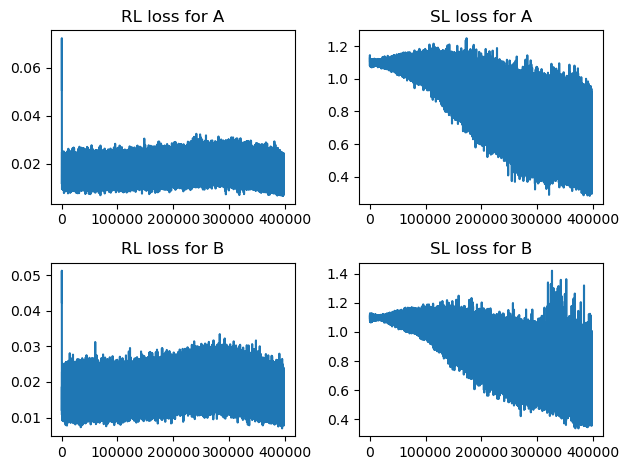

In [4]:
plt.subplot(2,2,1)
plt.plot(result['p1_loss'][0])
plt.title('RL loss for A')
plt.subplot(2,2,2)
plt.plot(result['p1_loss'][1])
plt.title('SL loss for A')
plt.subplot(2,2,3)
plt.plot(result['p2_loss'][0])
plt.title('RL loss for B')
plt.subplot(2,2,4)
plt.plot(result['p2_loss'][1])
plt.title('SL loss for B')
plt.tight_layout()
plt.savefig('fig/loss.png')

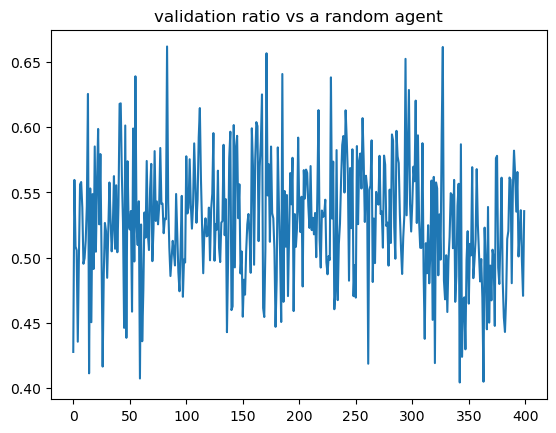

In [5]:
plt.plot(np.array(result['ratio'][1]))
plt.title('validation ratio vs a random agent')
plt.savefig('fig/val_ratio.png')

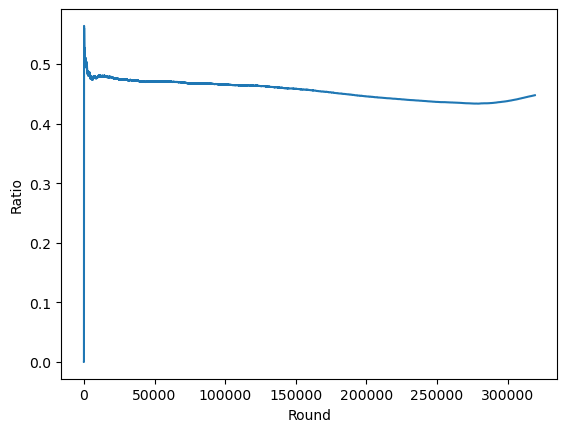

In [6]:
ratio = np.cumsum((np.array(result['p1_reward'])+1)/2)/np.arange(1,len(result['p1_reward'])+1)
plt.plot(ratio)
plt.xlabel('Round')
plt.ylabel('Ratio')
plt.savefig('fig/ratio.png')

In [37]:
def pk_ai(model,n_round = 100):
    move = ['攻击','护盾','充能']
    env = general_battle_env(print_info=True)
    A = env.player
    B = env.enemy
    for i in range(n_round):
        time.sleep(0)
        if A.hp==0 and B.hp==0:
            print('TIE')
            break
        elif A.hp ==0:
            print('Win: B')
            break
        elif B.hp ==0:
            print('Win: A')
            break
        time.sleep(0.3)
        a_t = model.act(torch.FloatTensor(env.get_status()[1]))
        action = input()#random.choice([0,1,2])
        print('palyer:',move[int(action)],'enemy:',move[int(a_t)])
        env.step(action_a=int(action),action_b=int(a_t))

In [72]:
pk_ai(result['p1_model'][1])

palyer: 充能 enemy: 护盾
charge: 2.0
HP of A:5, HP of B:5
palyer: 充能 enemy: 护盾
charge: 3.0
HP of A:5, HP of B:5
palyer: 充能 enemy: 护盾
charge: 4.0
SHIELD FAIL
HP of A:5, HP of B:5
palyer: 充能 enemy: 护盾
charge: 5.0
HP of A:5, HP of B:5
palyer: 充能 enemy: 护盾
charge: 6.0
HP of A:5, HP of B:5
palyer: 攻击 enemy: 护盾
SHIELD FAIL
HP of A:5, HP of B:0
Win: A


In [108]:
from common.utils import epsilon_scheduler

In [113]:
epsilon = []
max_frames = 2000000
eps_start = 1
eps_final = 0.02
eps_decay = 800000
eps = epsilon_scheduler(eps_start, eps_final, eps_decay)
for i in range(max_frames):
    epsilon.append(eps(i))


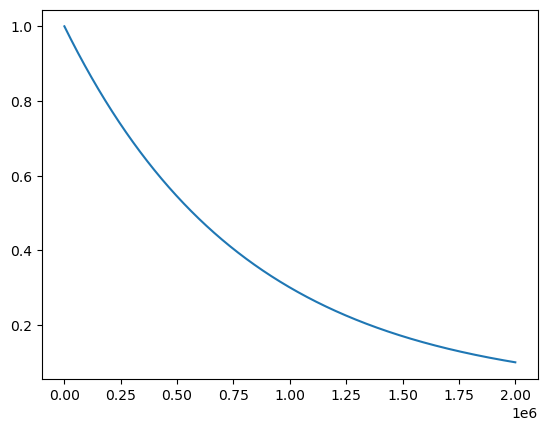

In [114]:
plt.plot(epsilon)

In [7]:
result['p1_model'][0].forward(torch.FloatTensor(np.array([5.,3.,1.,5.,1.,1.])).unsqueeze(0))

tensor([[-0.0792, -0.0577, -0.0521]], grad_fn=<SubBackward0>)

In [8]:
result['p1_model'][1].forward(torch.FloatTensor(np.array([5.,1.,1.,5.,1.,1.])).unsqueeze(0))

tensor([[0.7529, 0.0676, 0.1796]], grad_fn=<SoftmaxBackward0>)

In [9]:
result['p2_model'][1].forward(torch.FloatTensor(np.array([5.,1.,1.,5.,1.,1.])).unsqueeze(0))

tensor([[0.4470, 0.0750, 0.4781]], grad_fn=<SoftmaxBackward0>)

In [10]:
def pk_ai_sim_weisuo(model,n_round = 1000):
    win = 0
    n = 0
    ratio = []
    for i in tqdm(range(n_round)):
        env = general_battle_env(print_info=False)
        j = 0
        while not env.end:

            a_t = model.act(torch.FloatTensor(env.get_status()[1]))
            if j&1==0:#env.get_status()[0][2] == 0.25:
                action = 0
            else:
                action = 1
            j+=1
            env.step(action_a=int(action),action_b=int(a_t))
        n+=1
        win+=(1-env.result)
        ratio.append(win/n)
    return ratio,env

In [15]:
1&1

1

In [13]:
weisuo_ratio,weisuo_env = pk_ai_sim_weisuo(result['p2_model'][1])

  0%|          | 0/1000 [00:00<?, ?it/s]

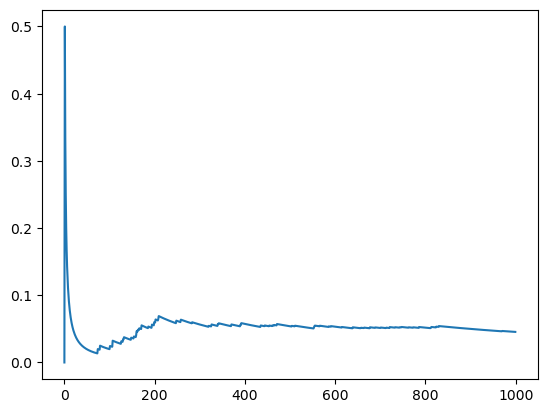

In [14]:
plt.plot(weisuo_ratio)

In [33]:
def pk_2_ai(model1,model2,n_round = 1000):
    win = 0
    n = 0
    ratio = []
    for i in tqdm(range(n_round)):
        env = general_battle_env(print_info=False)
        j = 0
        while not env.end:
            a_t = model2.act(torch.FloatTensor(env.get_status()[1]))
            action = model1.act(torch.FloatTensor(env.get_status()[0]))
            j+=1
            env.step(action_a=int(action),action_b=int(a_t))
        n+=1
        win+=(1-env.result)
        ratio.append(win/n)
    return ratio,env

In [34]:
mutal_ratio,env2 = pk_2_ai(result['p1_model'][1],result['p2_model'][1])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [36]:
env2.history

[[array([5., 1., 1., 5., 1., 1.]), 1, 2],
 [array([5. , 2. , 1. , 5. , 1. , 0.5]), 2, 2],
 [array([5., 3., 1., 5., 2., 1.]), 2, 1],
 [array([5. , 3. , 0.5, 5. , 3. , 1. ]), 1, 1],
 [array([5.  , 3.  , 0.25, 5.  , 3.  , 0.5 ]), 1, 2],
 [array([5., 4., 1., 5., 3., 1.]), 1, 1],
 [array([5. , 4. , 0.5, 5. , 3. , 0.5]), 1, 1],
 [array([5.  , 4.  , 1.  , 5.  , 3.  , 0.25]), 1, 1],
 [array([5.   , 4.   , 0.5  , 5.   , 3.   , 0.125]), 1, 1],
 [array([5.  , 4.  , 0.25, 5.  , 3.  , 1.  ]), 0, 1],
 [array([2., 4., 1., 5., 1., 1.]), 2, 1],
 [array([2. , 4. , 0.5, 5. , 2. , 1. ]), 1, 1],
 [array([2.  , 4.  , 0.25, 5.  , 2.  , 0.5 ]), 1, 1],
 [array([2., 4., 1., 5., 2., 1.]), 2, 1],
 [array([2. , 4. , 0.5, 5. , 3. , 1. ]), 1, 1],
 [array([2. , 4. , 1. , 5. , 3. , 0.5]), 1, 1],
 [array([2.  , 4.  , 0.5 , 5.  , 3.  , 0.25]), 2, 1],
 [array([2., 4., 1., 5., 4., 1.]), 1, 1],
 [array([2. , 4. , 0.5, 5. , 4. , 0.5]), 0, 1],
 [array([5.  , 4.  , 0.25, 5.  , 1.  , 1.  ]), 2, 1],
 [array([5., 4., 1., 5., 2.,

In [50]:
torch.save(result['p2_model'][1].state_dict(),'valuable_model/p2_policy_100w.pth')
torch.save(result['p2_model'][0].state_dict(),'valuable_model/p2_opt_100w.pth')
torch.save(result['p1_model'][1].state_dict(),'valuable_model/p1_policy_100w_good.pth')
torch.save(result['p1_model'][0].state_dict(),'valuable_model/p1_opt_100w.pth')